# Learn how to get a light yield

Tunnell, Feburary 2016

This tutorial describes how to use analyze the AmBe data to fit the inelastic line.

The following line just runs our standard code for every analysis.  You can change 'run' to 'load' to see what is in there.

In [86]:
%matplotlib inline
%run boiler_plate.py
import hax

In [87]:
## Specify your own data location
hax.config.CONFIG['main_data_paths'] = ['./data/']

## Load data

Grab the AmBe datasets then just use the first one:

In [88]:
datasets_ambe = hax.runs.DATASETS.query('source == "AmBe" & category == "standard" & tpc == "xenon100"')['name'].values
dataset = datasets_ambe[0]

Inspect this dataset

In [89]:
hax.runs.get_dataset_info(dataset)

{'anode': 4.4000000000000004,
 'category': 'standard',
 'cathode': 16.0,
 'comment': 'Trg 60/51, holdoff 1ms, HE veto (2x10dB/4/100/40)',
 'corrected_events': 5491.0,
 'corrected_livetime': 202.19999999999999,
 'events': 5491,
 'livetime': 202.16,
 'name': 'xe100_110210_1100',
 'position': 'other',
 'processed': '0.4.5',
 'run': '10',
 'shield': 'closed',
 'source': 'AmBe',
 'tpc': 'xenon100',
 'trigger': 'S1'}

In [90]:
df = hax.minitrees.load(dataset)
df.head(5)

Found minitree at ./xe100_110210_1100_Basics.root


,index,cs1,cs2,drift_time,event_number,event_time,largest_coincidence,largest_other_s1,largest_other_s2,largest_unknown,largest_veto,s1,s1_area_fraction_top,s2,s2_area_fraction_top,x,y,z
0,0,4.822919,439.419690,49639.042969,0,1297332001005216000,0,0,0.000000,0,0.000000,3.628556,0.215452,393.525543,0.593098,-12.639623,5.915094,-8.587554
1,1,NaN,NaN,NaN,1,1297332001027482112,0,0,0.000000,0,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,4.246333,488.037578,123562.687500,2,1297332001054971904,0,0,300.855682,0,0.000000,5.172802,0.000000,370.854065,0.566815,0.560377,-7.783019,-21.376345
3,3,NaN,NaN,NaN,3,1297332001141690880,0,0,534.971069,0,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,NaN,NaN,NaN,4,1297332001147309056,0,0,237.557007,0,203.871292,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Cuts

Here are the cuts

In [91]:
cut_single_s1 = (df['largest_other_s1'] == 0)
cut_single_s2 = (df['largest_other_s2'] < 100)
cut_radius = (np.sqrt(df['x']**2 + df['y']**2) < 12)
cut_z = (df['z'] < -5) & (df['z'] > -27)
cut_fiducial = (cut_radius & cut_z)
df = df[cut_single_s1 & cut_single_s2 & cut_fiducial]

Inspect $(x,y)$

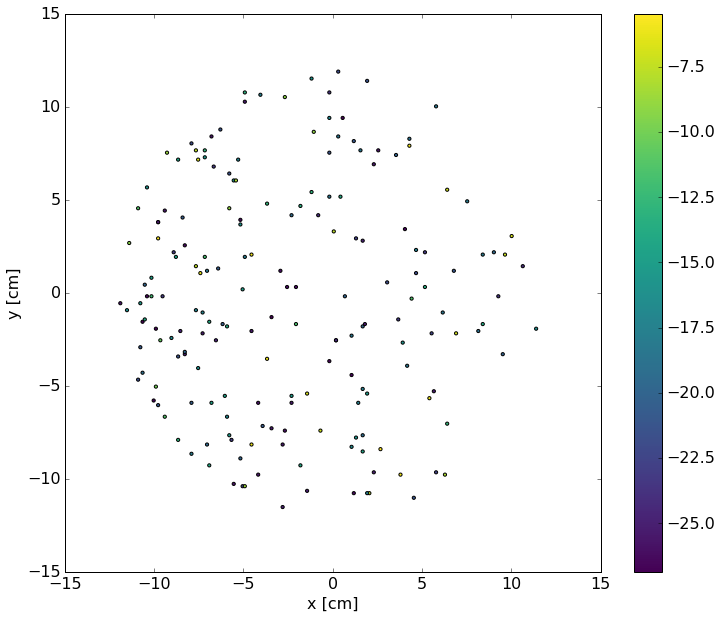

In [92]:
plt.scatter(df['x'],df['y'], c=df['z'], marker='o', s=10)
plt.colorbar()
plt.xlabel('x [cm]')
plt.ylabel('y [cm]')
plt.show()

Inspect $(r,z)$.

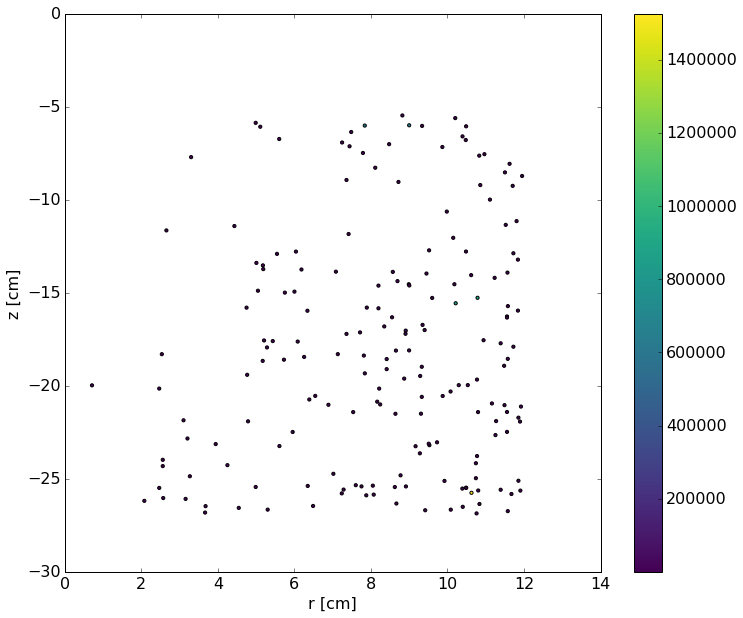

In [93]:
plt.scatter(np.sqrt(df['x']**2 + df['y']**2), df['z'], c=df['cs2'],
            marker='o', s=10)
plt.colorbar()
plt.xlabel('r [cm]')
plt.ylabel('z [cm]')

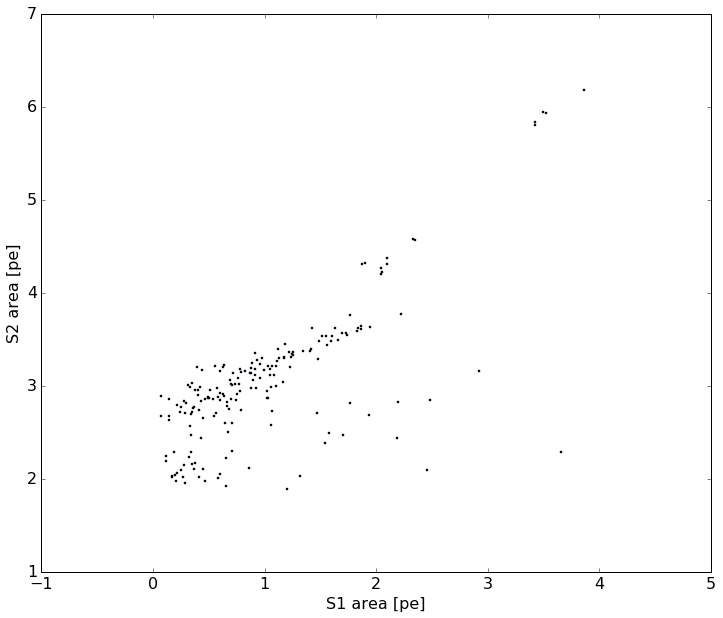

In [94]:
plt.scatter(np.log10(df['cs1']),
            np.log10(df['cs2']),
            marker='.',
            s=10,
            alpha=1)

plt.xlabel('S1 area [pe]')
plt.ylabel('S2 area [pe]')

plt.show()

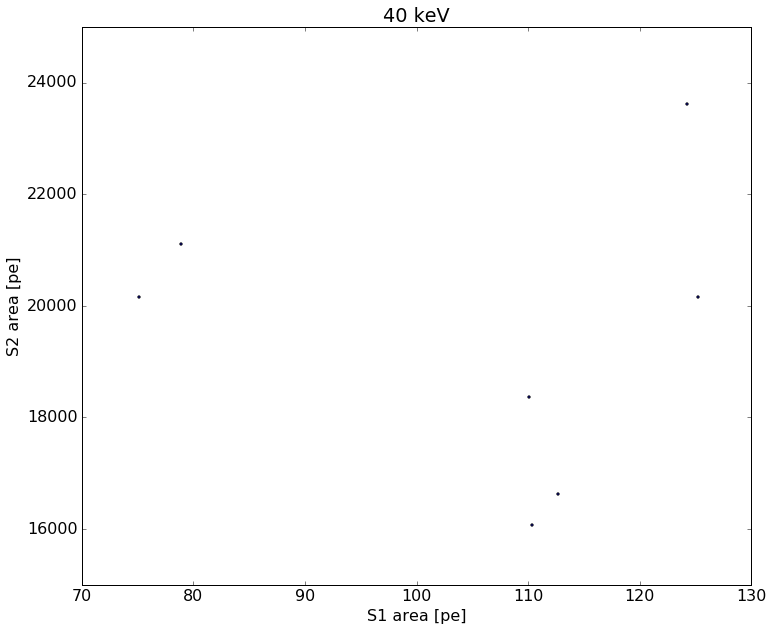

In [95]:
df_40kev = df[(df['cs1'] > 50) & (df['cs1'] < 200) & (df['cs2'] > 15000) & (df['cs2'] < 32000)]

plt.scatter(df_40kev['cs1'],
            df_40kev['cs2'], marker='.')
plt.title('40 keV')
#plt.xlim(0, 250) # S1
#plt.ylim(8000, 25000*2) # S2

plt.xlabel('S1 area [pe]')
plt.ylabel('S2 area [pe]')

plt.show()

In [96]:
print('S1 (40 keV) pe:', df_40kev['cs1'].mean(), '+/-', df_40kev['cs1'].std())
print('S2 (40 keV) pe:', df_40kev['cs2'].mean(), '+/-', df_40kev['cs2'].std())

S1 (40 keV) pe: 105.22526598422117 +/- 20.262830540250413
S2 (40 keV) pe: 19447.646313254172 +/- 2637.175876361584


In [97]:
print('S1 pe/keV:', df_40kev['cs1'].mean()/40)
print('S2 pe/keV:', df_40kev['cs2'].mean()/40)

S1 pe/keV: 2.630631649605529
S2 pe/keV: 486.1911578313543


In [98]:
df_peaks = df[(df['cs1'] > 50) & (df['cs1'] < 500) & (df['cs2'] > 15000) & (df['cs2'] < 300e5)]

In [99]:
# concatenate the two datasets into the final training set
X_train = np.dstack((df_peaks.to_records()['cs1'],
                     df_peaks.to_records()['cs2']))[0]

# fit a Gaussian Mixture Model with two components
clf = mixture.GMM(n_components=3, covariance_type='full')
clf.fit(X_train)

# display predicted scores by the model as a contour plot
x = np.linspace(df_peaks['cs1'].min(),
                df_peaks['cs1'].max())
                
y = np.linspace(df_peaks['cs2'].min(),
                df_peaks['cs2'].max())
X, Y = np.meshgrid(x, y)
XX = np.array([X.ravel(), Y.ravel()]).T
Z = -clf.score_samples(XX)[0]
Z = Z.reshape(X.shape)

CS = plt.contour(X, Y, Z, #norm=LogNorm(vmin=1.0, vmax=1000.0),
                 levels=np.logspace(1, 2, 100))
CB = plt.colorbar(CS, shrink=0.8, extend='both')
plt.scatter(X_train[:, 0], X_train[:, 1], .8)

plt.title('Negative log-likelihood predicted by a GMM')
plt.axis('tight')
plt.show()

ValueError: two fields with the same name

In [ ]:
clf.means_

In [ ]:
df_pid = df[(150 < df['s2_area']) & (10000 > df['s2_area'])]
plt.scatter(df_pid['s1_area'], df_pid['pid'], marker='.', alpha=0.1, s=5,
            color='red', label='NR band')
plt.scatter(df_40kev['s1_area'], df_40kev['pid'], marker='.', alpha=1.0, s=5,
            color='blue', label='40 keV $\gamma$')
plt.legend()
plt.xlabel('Corrected S1 [pe]')
plt.ylabel('log10(S2/s1)')
plt.xlim(0, 220)
plt.ylim(1,4)

In [ ]:
df_inspect = df_pid[df_pid['pid'] < 1.0]


In [ ]:
df_40kev['xed'] = df_40kev['dataset_name']

In [ ]:
df_40kev['dataset_name'] = [x[:-11] for x in df_40kev['dataset_name']]

In [ ]:
df_40kev.head()

In [ ]:
def inspect_event(df_event):
    mypax = core.Processor(config_names='XENON100',
                           config_dict={'pax': {
                 'output': ['Plotting.PlotEventSummary'],
                'input_name':   ('/Users/tunnell/XENON/data/xenon100/run_10/%s/%s' % (df_event['dataset_name'],
                                                                                       df_event['xed'])),
                'events_to_process': [df_event['event_number']],          
                'output_name': 'SCREEN'}})

    mypax.run()

In [ ]:
inspect_event(df_40kev.iloc[0])